Ref: https://arxiv.org/pdf/1711.10561

# Equação de Burgers

$$\left\{\begin{array}{l}
u_t + u u_x - (0.01/\pi) u_{xx} = 0, \ x \in [-1,1], \ t \in [0,1] \\
u(x,0) = -\sin(\pi x) \\
u(-1,t) = u(1,t) = 0
\end{array}\right.$$

#### Setup Inicial

In [2]:
#### Importando Bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import torch as tc

from time import perf_counter
from torch import nn
from torch.optim.lr_scheduler import StepLR
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp

# Detecção de GPU
device = tc.device('cuda' if tc.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cpu


#### Geração de Dados

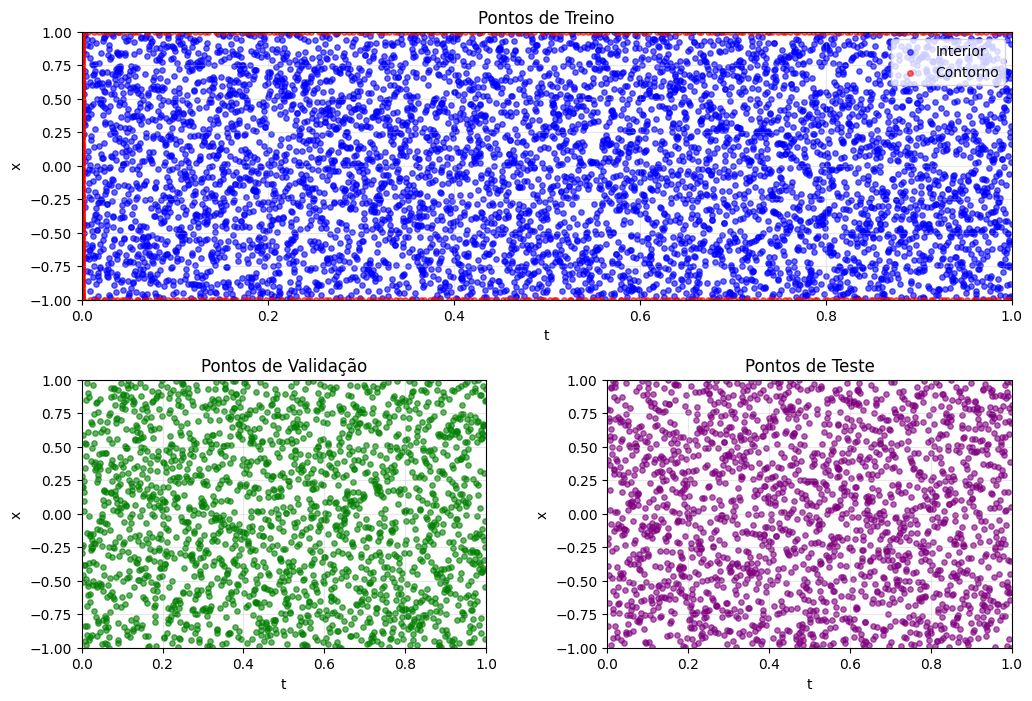

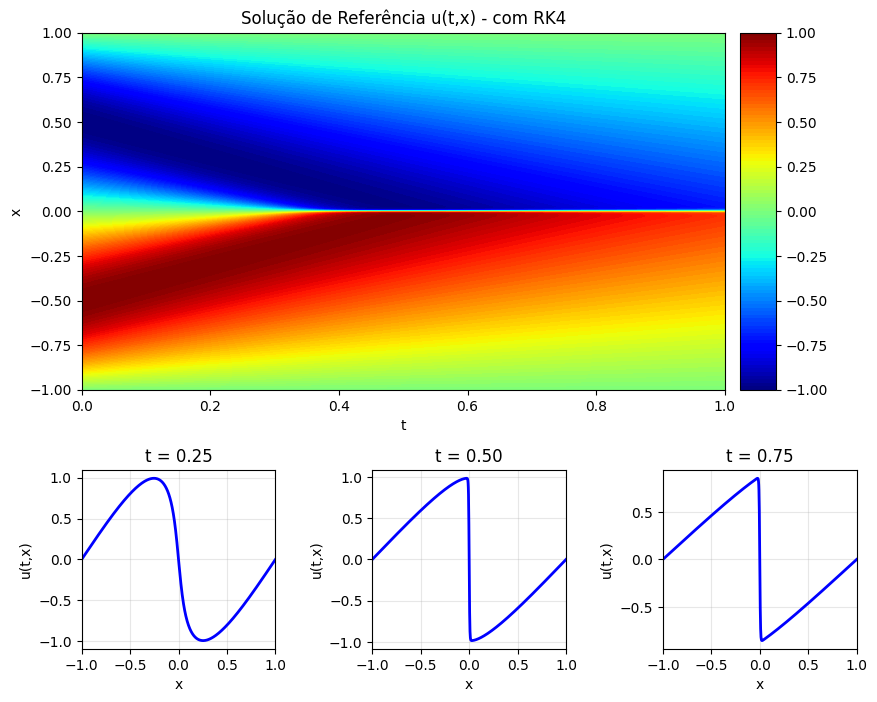

In [9]:
tc.manual_seed(21)

# Definindo domínio
x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0

# Número de pontos
n_ci = 200   # Pra cada condição de contorno(teste)
n = 10000    # Pontos usados no treino, validação e teste

distribution = [0.6, 0.2, 0.2] # Distribuição entre treino, validação e teste

# Hipercubo Latino 2D (para (x,t) ∈ [(x_min, x_max), (t_min, t_max)])
def latin_hypercube(n_points):
    intervals = tc.linspace(0, 1, n_points + 1)
    points = tc.zeros(n_points, 2)
    for i in range(2):
        perm = tc.randperm(n_points)
        points[:, i] = intervals[:-1] + (intervals[1] - intervals[0]) * tc.rand(n_points)
        points[:, i] = points[perm, i]
    
    # Escalar para o domínio definido
    points[:, 0] = points[:, 0] * (x_max - x_min) + x_min # x
    points[:, 1] = points[:, 1] * (t_max - t_min) + t_min # t
    return points

### ================================== ###
###    Condições Iniciais/Contorno     ###
### ================================== ###

# Pontos (x,t)
ci1 = latin_hypercube(n_ci)     # (x,t) = (:,0)
ci2 = latin_hypercube(n_ci)     # (x,t) = (1,:)
ci3 = latin_hypercube(n_ci)     # (x,t) = (-1,:)

ci1[:,1] = tc.zeros(n_ci)           # t = 0
ci2[:,0] = tc.full((n_ci,), 1.0)    # x = 1
ci3[:,0] = tc.full((n_ci,), -1.0)   # x = -1

treino_ci = tc.concatenate([ci1, ci2, ci3]) # (x,t) -> shape: [3*n_ci, 2]

# Soluções u(x,t)
ci1_u = -tc.sin(tc.pi*ci1[:,0])     # u(x,0) -> shape: [n_ci]
ci2_u = tc.zeros(n_ci)              # u(1,t) -> shape: [n_ci]
ci3_u = tc.zeros(n_ci)              # u(-1,t) -> shape: [n_ci]

treino_ci_u = tc.concatenate([ci1_u, ci2_u, ci3_u]).unsqueeze(1).to(device) # (x,t) -> shape: [3*n_ci, 1]

### ==================================== ###
###  Dados de treino, validação e teste  ###
### ==================================== ###

n_treino = int(n*distribution[0])
n_validacao = int(n*distribution[1])
n_teste = int(n*distribution[2])

# Pontos (x,t) - treino
treino_geral = latin_hypercube(n_treino)               # (x,t) -> shape: [n_treino, 2]
treino = tc.cat([treino_ci, treino_geral]).to(device)  # (x,t) -> shape: [3*n_ci + n_treino, 2]
treino.requires_grad_(True)

# Pontos (x,t) - validação
validacao = latin_hypercube(n_validacao).to(device)    # (x,t) -> shape: [n_validacao, 2]

# Pontos (x,t) - teste
teste = latin_hypercube(n_teste).to(device)            # (x,t) -> shape: [n_teste, 2]

### ========================================= ###
###   Solução Referencia(validação e teste)   ###
### ========================================= ###

# Parâmetros da malha de referência
nx = 1024      # Aumentar para melhor resolução espacial
nt = 10001     # Aumentar para melhor estabilidade (dt menor)
x_ref = np.linspace(x_min, x_max, nx)
t_ref = np.linspace(t_min, t_max, nt)
dx = x_ref[1] - x_ref[0]
dt = t_ref[1] - t_ref[0]
nu = 0.01 / np.pi

# Inicialização da solução na malha regular
u_ref = np.zeros((nt, nx), dtype=np.float64)
u_ref[0, :] = -np.sin(np.pi * x_ref)

# Função RHS de Burgers (diferenças centrais)
def rhs(u):
    dudx = (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx)
    d2udx2 = (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2
    return -u * dudx + nu * d2udx2

# Integração temporal (RK4 explícito)
for n in range(nt - 1):
    u = u_ref[n]
    k1 = rhs(u)
    k2 = rhs(u + 0.5 * dt * k1)
    k3 = rhs(u + 0.5 * dt * k2)
    k4 = rhs(u + dt * k3)
    u_next = u + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    u_next[0] = 0.0
    u_next[-1] = 0.0
    u_ref[n + 1] = u_next

# Interpolador para pontos arbitrários (x, t)
interp = RegularGridInterpolator((t_ref, x_ref), u_ref, bounds_error=False, fill_value=0.0)

def get_u_tensor(points):
    # points: tensor shape [N, 2] com (x, t)
    pts_np = points.detach().cpu().numpy()
    # scipy espera (t, x)
    pts_np = np.stack([pts_np[:,1], pts_np[:,0]], axis=1)
    u_np = interp(pts_np)
    return tc.tensor(u_np, dtype=tc.float32, device=points.device).unsqueeze(1)

validacao_u = get_u_tensor(validacao)     # u(x,t) -> shape: [n_validacao, 1]
teste_u = get_u_tensor(teste)             # u(x,t) -> shape: [n_teste, 1]

### ================================================ ###
###   Plotando Pontos de Treino, Teste e Validação   ###
### ================================================ ###
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Treino (ocupa primeira linha, 2 colunas)
ax_treino = fig.add_subplot(gs[0, :])
ax_treino.scatter(treino_geral[:,1].detach().numpy(), treino_geral[:,0].detach().numpy(), c='blue', s=15, label='Interior', alpha=0.6)
ax_treino.scatter(ci1[:,1].detach().numpy(), ci1[:,0].detach().numpy(), c='red', label='Contorno', s=15, alpha=0.6)
ax_treino.scatter(ci2[:,1].detach().numpy(), ci2[:,0].detach().numpy(), c='red', s=15, alpha=0.6)
ax_treino.scatter(ci3[:,1].detach().numpy(), ci3[:,0].detach().numpy(), c='red', s=15, alpha=0.6)
ax_treino.set_xlabel('t')
ax_treino.set_ylabel('x')
ax_treino.set_title('Pontos de Treino')
ax_treino.set_xlim(t_min, t_max)
ax_treino.set_ylim(x_min, x_max)
ax_treino.legend(loc='upper right')
ax_treino.grid(True, alpha=0.3)

# Validação (segunda linha, coluna 1)
ax_val = fig.add_subplot(gs[1, 0])
ax_val.scatter(validacao[:,1].detach().cpu().numpy(), validacao[:,0].detach().cpu().numpy(), c='green', s=15, alpha=0.6)
ax_val.set_xlabel('t')
ax_val.set_ylabel('x')
ax_val.set_title('Pontos de Validação')
ax_val.set_xlim(t_min, t_max)
ax_val.set_ylim(x_min, x_max)
ax_val.grid(True, alpha=0.3)

# Teste (segunda linha, coluna 2)
ax_teste = fig.add_subplot(gs[1, 1])
ax_teste.scatter(teste[:,1].detach().cpu().numpy(), teste[:,0].detach().cpu().numpy(), c='purple', s=15, alpha=0.6)
ax_teste.set_xlabel('t')
ax_teste.set_ylabel('x')
ax_teste.set_title('Pontos de Teste')
ax_teste.set_xlim(t_min, t_max)
ax_teste.set_ylim(x_min, x_max)
ax_teste.grid(True, alpha=0.3)

plt.show()

### ======================================== ###
###   Visualizando Solução de Referência     ###
### ======================================== ###

# Pontos treino + validação
pts_tv = tc.cat([treino_geral.cpu(), validacao.cpu()]).detach().cpu()
u_tv = get_u_tensor(pts_tv).detach().cpu().numpy().flatten()

# Grid para contorno
t_grid, x_grid = np.meshgrid(t_ref, x_ref, indexing='ij')

# Tempos para perfis
t_perfis = [0.25, 0.5, 0.75]

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 3, height_ratios=[2, 1], hspace=0.3, wspace=0.5)

# Mapa de calor principal
ax_main = fig.add_subplot(gs[0, :])
im = ax_main.contourf(t_grid, x_grid, u_ref, levels=100, cmap='jet', vmin=-1, vmax=1)
ax_main.set_xlabel('t')
ax_main.set_ylabel('x')
ax_main.set_title('Solução de Referência u(t,x) - com RK4')
ax_main.set_xlim(t_min, t_max)
ax_main.set_ylim(x_min, x_max)
cbar = plt.colorbar(im, ax=ax_main, pad=0.02, aspect=10, ticks=np.arange(-1, 1.25, 0.25))

# Perfis temporais
for i, t_val in enumerate(t_perfis):
    ax = fig.add_subplot(gs[1, i])
    idx_t = np.argmin(np.abs(t_ref - t_val))
    ax.plot(x_ref, u_ref[idx_t, :], 'b-', linewidth=2)
    ax.set_xlabel('x')
    ax.set_ylabel('u(t,x)')
    ax.set_title(f't = {t_val:.2f}')
    ax.set_xlim(x_min, x_max)
    ax.grid(True, alpha=0.3)

plt.show()

#### Definindo rede neural

In [4]:
class PINN(nn.Module):

    def __init__(self, structure=[1, 10, 10, 1], activation=nn.Tanh()):
        super(PINN, self).__init__()
        self.structure = structure
        self.activation = activation
        self.hidden_layers = nn.ModuleList()

        for i in range(len(structure)-1):
            self.hidden_layers.append(nn.Linear(structure[i], structure[i+1]))
            
    
    def forward(self, x):
        for layer in self.hidden_layers[:-1]:
            x = self.activation(layer(x))
        x = self.hidden_layers[-1](x) # Sem ativação na última camada
        return x

#### Treino

In [11]:
tc.manual_seed(21)

hidden_leyers = 20
neurons_per_leyer = 60
f = PINN(structure=[2] + [neurons_per_leyer] * hidden_leyers + [1], activation=nn.Tanh())
f.to(device)

optimizer = tc.optim.Adam(f.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1000, gamma=1)

loss_log = []
epochs = 2
start_time = perf_counter()

for epoch in range(epochs+1):
    u = f(treino) # inferencia dos dados de treino

    # Derivadas Parciais
    grad_u = tc.autograd.grad(u, treino, grad_outputs=tc.ones_like(u), create_graph=True, retain_graph=True)[0]
    du_dx = grad_u[:, 0]
    du_dt = grad_u[:, 1]
    d2u_dx2 = tc.autograd.grad(du_dx, treino, grad_outputs=tc.ones_like(du_dx), create_graph=True, retain_graph=True)[0][:, 0]

    loss_EDP = tc.mean((du_dt + u*du_dx - tc.tensor(0.01/np.pi)*d2u_dx2)**2)    # EDP
    loss_ci1 = tc.mean((u[:n_ci] - treino_ci_u[:n_ci])**2)                      # u(x,0)
    loss_ci2 = tc.mean((u[n_ci:2*n_ci] - treino_ci_u[n_ci:2*n_ci])**2)          # u(1,t)
    loss_ci3 = tc.mean((u[2*n_ci:3*n_ci] - treino_ci_u[2*n_ci:3*n_ci])**2)      # u(-1,t)
    loss_ci = loss_EDP + loss_ci1 + loss_ci2 + loss_ci3
    loss = loss_ci
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Salvando loss e printando a cada 1000 epochs
    loss_log.append([loss.item(), loss_EDP.item(), loss_ci.item()])
    if epoch % 250 == 0:
        end_time = perf_counter()
        print(f"Epoch {epoch} - Loss: {loss.item():.2e} - Time: {end_time - start_time:.2f}s")
        start_time = perf_counter()

Epoch 0 - Loss: 5.00e-01 - Time: 0.61s


#### Plot da loss

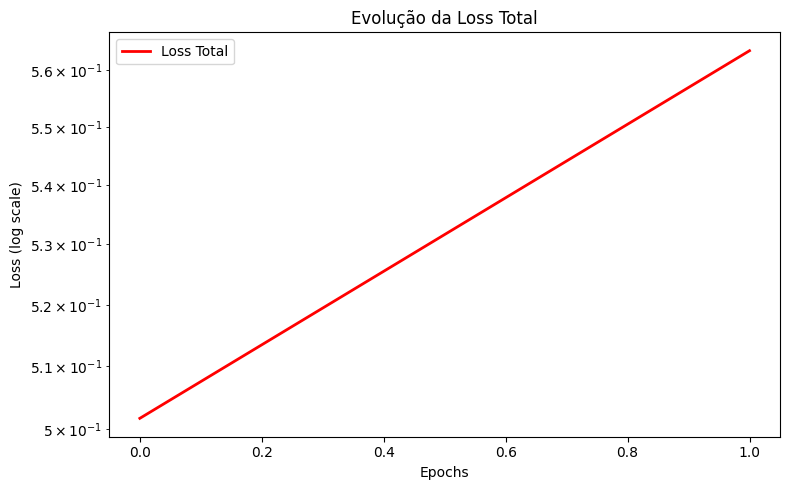

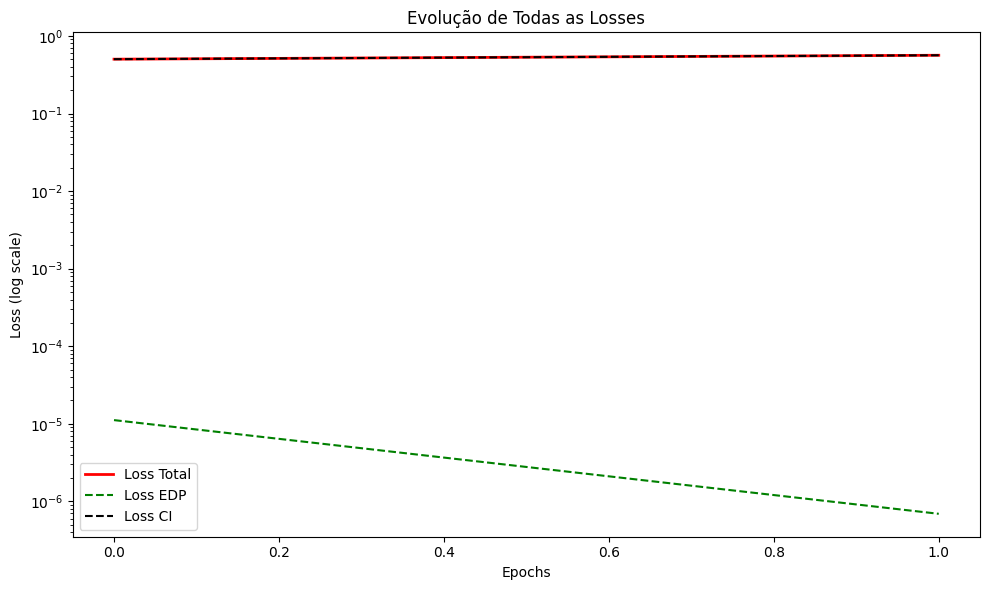

In [6]:
loss_array = np.array(loss_log)

# Figura 1: Apenas Loss Total
plt.figure(figsize=(8,5))
plt.semilogy(loss_array[:, 0], 'r-', linewidth=2, label='Loss Total')
plt.ylabel("Loss (log scale)")
plt.xlabel("Epochs")
plt.legend()
plt.title("Evolução da Loss Total")
plt.tight_layout()
plt.show()

# Figura 2: Todas as Losses
plt.figure(figsize=(10,6))
plt.semilogy(loss_array[:, 0], 'r-', linewidth=2, label='Loss Total')
plt.semilogy(loss_array[:, 1], 'g--', linewidth=1.5, label='Loss EDP')
plt.semilogy(loss_array[:, 2], 'k--', linewidth=1.5, label='Loss CI')
plt.ylabel("Loss (log scale)")
plt.xlabel("Epochs")
plt.legend()
plt.title("Evolução de Todas as Losses")
plt.tight_layout()
plt.show()

#### Comparação: Referência vs. Predição

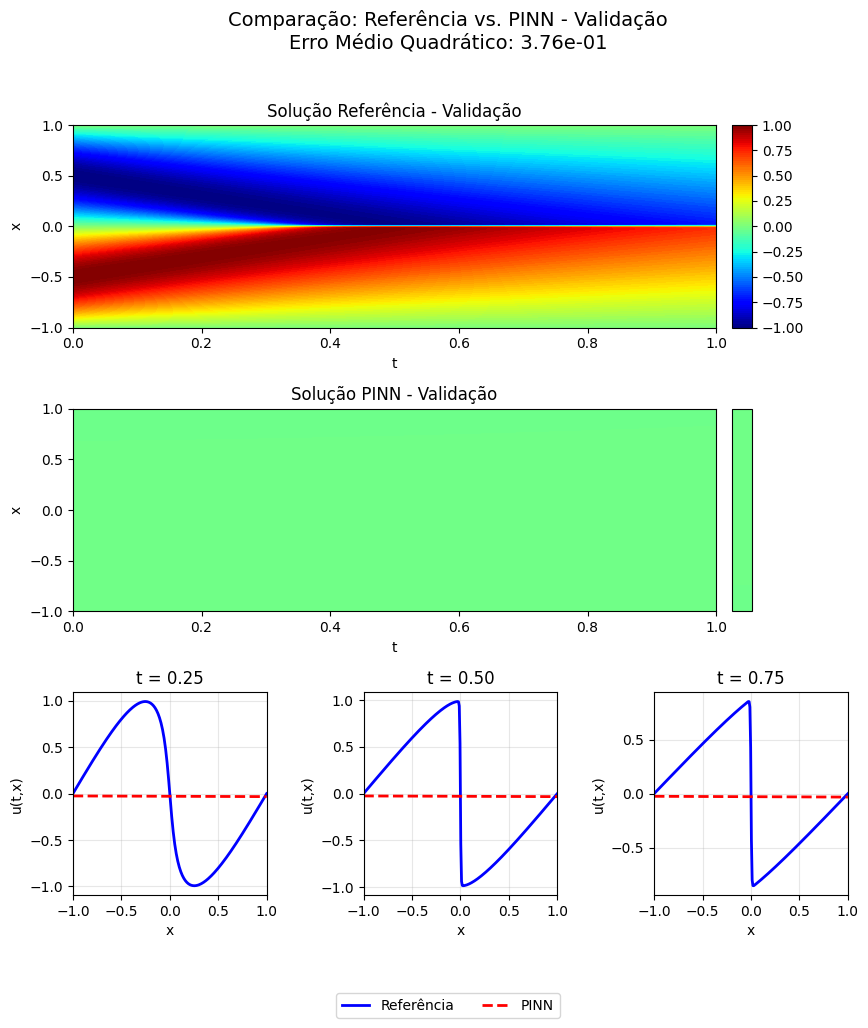

In [8]:
comparison = 1  # validacao(1) ou teste(2)

# Seleção de dados
pts_comp = validacao if comparison == 1 else teste
u_comp_ref = validacao_u if comparison == 1 else teste_u
label_comp = 'Validação' if comparison == 1 else 'Teste'

# Predição da rede
with tc.no_grad():
    u_comp_pred = f(pts_comp)

# Erro médio
erro_medio = tc.mean((u_comp_pred - u_comp_ref)**2).item()

# Grid para interpolação das predições
nx_grid = 256
nt_grid = 256
x_grid_1d = np.linspace(x_min, x_max, nx_grid)
t_grid_1d = np.linspace(t_min, t_max, nt_grid)
t_grid, x_grid = np.meshgrid(t_grid_1d, x_grid_1d, indexing='ij')

# Criar tensor de pontos para predição
pts_grid = tc.tensor(np.stack([x_grid.flatten(), t_grid.flatten()], axis=1), dtype=tc.float32, device=device)
with tc.no_grad():
    u_pred_grid = f(pts_grid).cpu().numpy().reshape(nt_grid, nx_grid)

# Interpolação da referência no grid
u_ref_grid = interp(np.stack([t_grid.flatten(), x_grid.flatten()], axis=1)).reshape(nt_grid, nx_grid)

# Tempos para perfis
t_perfis = [0.25, 0.5, 0.75]

# Plot
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.5)

fig.suptitle(f'Comparação: Referência vs. PINN - {label_comp}\nErro Médio Quadrático: {erro_medio:.2e}', fontsize=14, y=0.995)

# Colormap referência
ax1 = fig.add_subplot(gs[0, :])
im1 = ax1.contourf(t_grid, x_grid, u_ref_grid, levels=100, cmap='jet', vmin=-1, vmax=1)
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title(f'Solução Referência - {label_comp}')
ax1.set_xlim(t_min, t_max)
ax1.set_ylim(x_min, x_max)
cbar1 = plt.colorbar(im1, ax=ax1, pad=0.02, aspect=10, ticks=np.arange(-1, 1.25, 0.25))

# Colormap predição
ax2 = fig.add_subplot(gs[1, :])
im2 = ax2.contourf(t_grid, x_grid, u_pred_grid, levels=100, cmap='jet', vmin=-1, vmax=1)
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title(f'Solução PINN - {label_comp}')
ax2.set_xlim(t_min, t_max)
ax2.set_ylim(x_min, x_max)
cbar2 = plt.colorbar(im2, ax=ax2, pad=0.02, aspect=10, ticks=np.arange(-1, 1.25, 0.25))

# Perfis temporais
handles, labels = None, None
for i, t_val in enumerate(t_perfis):
    ax = fig.add_subplot(gs[2, i])
    idx_t = np.argmin(np.abs(t_grid_1d - t_val))
    l1, = ax.plot(x_grid_1d, u_ref_grid[idx_t, :], 'b-', linewidth=2, label='Referência')
    l2, = ax.plot(x_grid_1d, u_pred_grid[idx_t, :], 'r--', linewidth=2, label='PINN')
    ax.set_xlabel('x')
    ax.set_ylabel('u(t,x)')
    ax.set_title(f't = {t_val:.2f}')
    ax.set_xlim(x_min, x_max)
    ax.grid(True, alpha=0.3)
    if i == 0:
        handles, labels = [l1, l2], ['Referência', 'PINN']

# Legenda centralizada abaixo
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), frameon=True)

plt.show()

